# A/B-тесты

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Пример-анализа-результатов-A/B-теста" data-toc-modified-id="Пример-анализа-результатов-A/B-теста-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Пример анализа результатов A/B-теста</a></span></li><li><span><a href="#Сбор-данных" data-toc-modified-id="Сбор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Сбор данных</a></span><ul class="toc-item"><li><span><a href="#Готовая-агрегирующая-функция" data-toc-modified-id="Готовая-агрегирующая-функция-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Готовая агрегирующая функция</a></span></li></ul></li><li><span><a href="#Графики" data-toc-modified-id="Графики-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Графики</a></span></li><li><span><a href="#Анализ-всплесков-и-выбросов" data-toc-modified-id="Анализ-всплесков-и-выбросов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ всплесков и выбросов</a></span></li><li><span><a href="#Полный-анализ-A/B-теста" data-toc-modified-id="Полный-анализ-A/B-теста-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Полный анализ A/B-теста</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных-к-обработке" data-toc-modified-id="Загрузка-и-подготовка-данных-к-обработке-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Загрузка и подготовка данных к обработке</a></span></li><li><span><a href="#Исключаем-аномальные-явления-из-выборок" data-toc-modified-id="Исключаем-аномальные-явления-из-выборок-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Исключаем аномальные явления из выборок</a></span><ul class="toc-item"><li><span><a href="#Пользователи,-оформившие-очень-много-заявок" data-toc-modified-id="Пользователи,-оформившие-очень-много-заявок-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Пользователи, оформившие очень много заявок</a></span></li></ul></li><li><span><a href="#Статистическая-значимость-различий-между-группами-теста" data-toc-modified-id="Статистическая-значимость-различий-между-группами-теста-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Статистическая значимость различий между группами теста</a></span><ul class="toc-item"><li><span><a href="#Различие-в-количестве-заказов" data-toc-modified-id="Различие-в-количестве-заказов-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>Различие в количестве заказов</a></span></li></ul></li></ul></li><li><span><a href="#Основные-ошибки-при-анализе" data-toc-modified-id="Основные-ошибки-при-анализе-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Основные ошибки при анализе</a></span></li></ul></div>

## Пример анализа результатов A/B-теста

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

BASE_URL = 'https://code.s3.yandex.net/datasets/'

In [2]:
data = pd.read_csv(BASE_URL + 'lesson_data_3-3.csv')
data.head(5)

,date,group,visitors,orders
0,1/1/2019,A,1013,10
1,1/2/2019,A,969,13
2,1/3/2019,A,1004,13
3,1/4/2019,A,1006,12
4,1/5/2019,A,968,14


In [3]:
data_new = data.groupby('group', as_index=False).agg(
    {'visitors': 'sum', 'orders': 'sum'}
)
data_new

,group,visitors,orders
0,A,30996,385
1,B,31105,419


In [4]:
data_new['orders_to_visitors_ratio'] = data['orders'] * 100 / data['visitors']
data_new

,group,visitors,orders,orders_to_visitors_ratio
0,A,30996,385,0.987167
1,B,31105,419,1.341589


Видим, что количестов заказов на пользователя во втором случае больше, чем в первом.

## Сбор данных

In [5]:
orders = pd.read_csv(BASE_URL + 'orders_for_anomalies_detection.csv', sep=',')
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors = pd.read_csv(
    BASE_URL + 'orders_for_anomalies_detection_visitors.csv', sep=','
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%d/%m/%Y')
)

print(orders.head())
print(visitors.head())

   orderId group                userId  revenue       date
0        1     A   4765212904118882304     7503 2019-04-01
1        2     A  14477413223818084352    11424 2019-04-01
2        3     B  10223965268965748736     1299 2019-04-01
3        4     A   1399771946645095424      999 2019-04-01
4        5     A  13269081434837460992      499 2019-04-01
        date group  visitors
0 2019-04-01     A       455
1 2019-04-02     A       501
2 2019-04-03     A      1313
3 2019-04-04     A       555
4 2019-04-05     A       564


In [6]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-04-01,A
2,2019-04-01,B
9,2019-04-02,A
10,2019-04-02,B
19,2019-04-03,B


In [7]:
# получаем агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'orderId': 'nunique',
            'userId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

print(ordersAggregated.head())

         date group  orderId  userId  revenue
0  2019-04-01     A        6       6   128276
2  2019-04-01     B        3       3     4082
9  2019-04-02     A       12      12   157683
10 2019-04-02     B        7       6   136535
20 2019-04-03     A       23      20   199868


In [8]:
# получаем агрегированные кумулятивные по дням данные
# о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

print(visitorsAggregated.head())

         date group  visitors
0  2019-04-01     A       455
2  2019-04-01     B       464
9  2019-04-02     A       956
10 2019-04-02     B       977
20 2019-04-03     A      2269


In [9]:
# объединяем кумулятивные данные в одной таблице
# и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated,
    on=['date', 'group'],
    how='outer',
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-04-01     A       6       6   128276       455
1 2019-04-01     B       3       3     4082       464
2 2019-04-02     A      12      12   157683       956
3 2019-04-02     B       7       6   136535       977
4 2019-04-03     A      23      20   199868      2269


### Готовая агрегирующая функция

In [10]:
def agg_ab_data(
    visits_by_timeframe,
    orders,
    group_col='group',
    timeframe_col='date',
    order_id_col='order_id',
    user_id_col='user_id',
    revenue_col='revenue',
):

    # создаем массив уникальных пар значений дат и групп теста
    dates_groups = visits_by_timeframe[
        [timeframe_col, group_col]
    ].drop_duplicates()

    # получаем агрегированные кумулятивные по дням данные о числе заказов
    orders_aggregated = (
        dates_groups.apply(
            lambda row: orders[
                np.logical_and(
                    orders[timeframe_col] <= row[timeframe_col],
                    orders[group_col] == row[group_col],
                )
            ].agg(
                {
                    timeframe_col: 'max',
                    group_col: 'max',
                    order_id_col: 'nunique',
                    user_id_col: 'nunique',
                    revenue_col: 'sum',
                }
            ),
            axis=1,
        )
        .sort_values(by=[timeframe_col, group_col])
        .rename(columns={order_id_col: 'orders', user_id_col: 'buyers'})
    )

    # получаем кумулятивные по дням данные о числе посетителей
    visitors_aggregated = dates_groups.apply(
        lambda row: visits_by_timeframe[
            np.logical_and(
                visits_by_timeframe[timeframe_col] <= row[timeframe_col],
                visits_by_timeframe[group_col] == row[group_col],
            )
        ].agg({timeframe_col: 'max', group_col: 'max', 'visitors': 'sum'}),
        axis=1,
    ).sort_values(by=[timeframe_col, group_col])

    # соединяем данные по таймфреймам и группам
    ab_data = orders_aggregated.merge(
        visitors_aggregated,
        on=[timeframe_col, group_col],
        how='outer',
    )

    return ab_data

In [11]:
cumulativeData = agg_ab_data(
    visitors,
    orders,
    group_col='group',
    timeframe_col='date',
    order_id_col='orderId',
    user_id_col='userId',
    revenue_col='revenue',
)
print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-04-01     A       6       6   128276       455
1 2019-04-01     B       3       3     4082       464
2 2019-04-02     A      12      12   157683       956
3 2019-04-02     B       7       6   136535       977
4 2019-04-03     A      23      20   199868      2269


## Графики

In [12]:
import matplotlib.pyplot as plt

# датафрейм с кумулятивным количеством заказов
# и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]

# датафрейм с кумулятивным количеством заказов
# и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

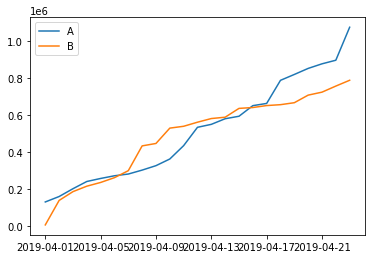

In [13]:
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Хороший знак.

Однако графики выручки обеих групп в нескольких точках резко растут. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Такие выбросы проанализируем в следующем уроке.

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

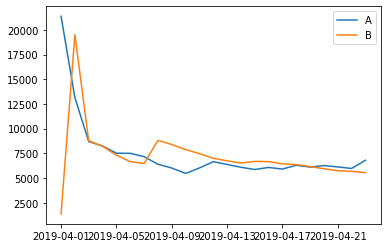

In [14]:
plt.plot(
    cumulativeRevenueA['date'],
    cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'],
    label='A',
)
plt.plot(
    cumulativeRevenueB['date'],
    cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'],
    label='B',
)
plt.legend()
plt.show()

Средний чек тоже становится равномерным ближе к концу теста: установился для группы A и продолжает падать для группы B. Возможно, в группу B в первой половине теста попали крупные заказы (резкий всплеск на графике). Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline() (от англ. horizontal line across the axis*, «горизонтальная линия поперек оси»):

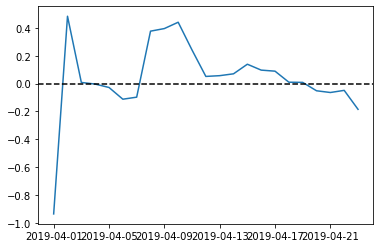

In [15]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB,
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['A', 'B'],
)

# cтроим отношение средних чеков
plt.plot(
    mergedCumulativeRevenue['date'],
    (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB'])
    / (
        mergedCumulativeRevenue['revenueA']
        / mergedCumulativeRevenue['ordersA']
    )
    - 1,
)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

В нескольких точках график различия между сегментами резко «скачет». Где-то уж точно спрятались крупные заказы и выбросы! Найдём их позже.

Аналогично проанализируем график кумулятивной конверсии. Зададим масштаб осей методом `plt.axis()`. Передадим ему минимальное и максимальное значения оси `x`; минимальное и максимальное значения оси `y` — `["2019-04-01", '2019-04-23', 0, 0.015]`:

Внимание, тут "конверсия" - это просто количество заказов в пересчёте на количество визитов.

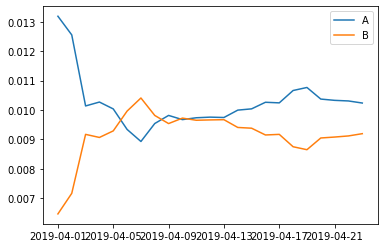

In [16]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visitors']
)

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
# plt.axis(['2019-04-01', '2019-04-23', 0, 0.015])
plt.show()

Симметричный график получился! Группы колебались около одного значения, но затем конверсия группы A вырвалась вперёд и зафиксировалась, а конверсия группы B просела и также зафиксировалась.

Построим график относительного различия кумулятивных конверсий:

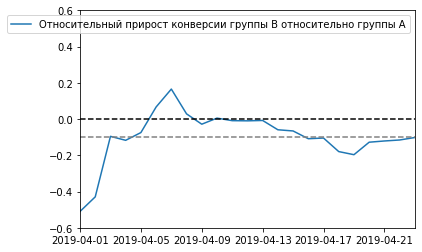

In [17]:
mergedCumulativeConversions = cumulativeDataA[['date', 'conversion']].merge(
    cumulativeDataB[['date', 'conversion']],
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['A', 'B'],
)

plt.plot(
    mergedCumulativeConversions['date'],
    mergedCumulativeConversions['conversionB']
    / mergedCumulativeConversions['conversionA']
    - 1,
    label="Относительный прирост конверсии группы B относительно группы A",
)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([dt.date(2019, 4, 1), dt.date(2019, 4, 23), -0.6, 0.6])
plt.show()

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Потом её конверсия снова падала, но теперь постепенно растёт.

В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину. Сделаем это в следующем уроке.

## Анализ всплесков и выбросов

In [18]:
import pandas as pd
import datetime as dt

data = pd.read_csv(BASE_URL + 'orders_for_anomalies_detection.csv', sep=',')
data['date'] = data['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

print(data.head(10))

   orderId group                userId  revenue       date
0        1     A   4765212904118882304     7503 2019-04-01
1        2     A  14477413223818084352    11424 2019-04-01
2        3     B  10223965268965748736     1299 2019-04-01
3        4     A   1399771946645095424      999 2019-04-01
4        5     A  13269081434837460992      499 2019-04-01
5        6     B   7141419942738429952      482 2019-04-01
6        7     A  14179588155630520320     2999 2019-04-01
7        8     A   1225733206606480128   104852 2019-04-01
8        9     B   3362287473339592192     2301 2019-04-01
9       10     A  11670724616393357312      499 2019-04-02


Есть существенный разлёт значений. 4 из 10 - менее 1 тыс руб, 1 из 10 - более 100 тыс руб. Проанализируем распределение с помощью гистограмм.

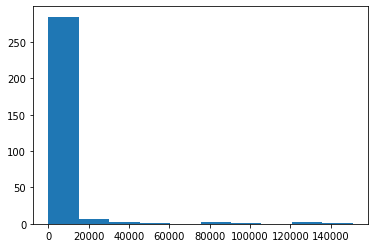

In [19]:
plt.hist(data['revenue'])
plt.show()

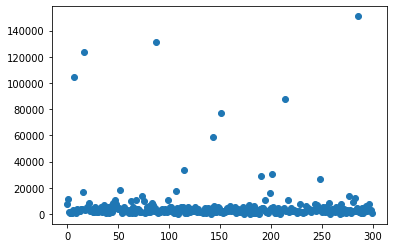

In [20]:
x_values = pd.Series(range(0, len(data['revenue'])))
plt.scatter(x_values, data['revenue'])
plt.show()

Дорогие заказы стоят отдельными точками.

Обычно от 1 до 5% крайних значений - выбрасывают.

Считаем, какие значения укладываются в 90, 95 и 99 перцентили.

In [21]:
print(np.percentile(data['revenue'], [90, 95, 99]))

[  8113.8   13817.   105038.04]


Подсчитаем количество заказов по пользователям и посмотрим на результат:

In [22]:
import pandas as pd
import datetime as dt

data = pd.read_csv(BASE_URL + 'orders_for_anomalies_detection.csv', sep=',')
data['date'] = data['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

ordersByUsers = data.groupby('userId', as_index=False).agg(
    {'orderId': 'nunique'}
)

ordersByUsers.columns = ['userId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

                   userId  orders
103  10915146588096065536      15
171  17524390106492114944      10
26    2181679483747416832       8
13    1072811847256720512       7
126  12759566205054128128       6
148  14477413223818084352       6
28    2332073096806479360       6
20    1577273240726417664       5
41    3362287473339592192       5
11     923223027330505600       5


Оценим распределение пользователей по количеству сделанных заказов.

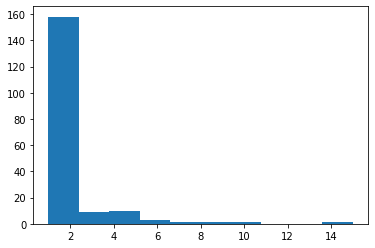

In [23]:
import matplotlib.pyplot as plt

plt.hist(ordersByUsers['orders'])
plt.show()

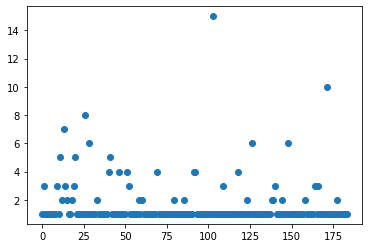

In [24]:
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.show()

Ну, больше одного мало кто заказал. Непонятно, считать ли тех, у кого по 2-4 заказа, особенными, аномальными.

In [25]:
import numpy as np

print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[3.   4.85 8.34]


Не более 5% пользователей оформляли больше чем 4.85 (т. е. 5) заказов. И 10% пользователей заказывали более трёх раз.

Разумным станет оставить только тех, кто ниже 95-го перцентиля в обоих случаях.

## Полный анализ A/B-теста

### Загрузка и подготовка данных к обработке

In [26]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np

# load and format data
orders = pd.read_csv(BASE_URL + 'orders_for_anomalies_detection.csv', sep=',')
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
print(orders.head(5))


visitors = pd.read_csv(
    BASE_URL + 'orders_for_anomalies_detection_visitors.csv', sep=','
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%d/%m/%Y')
)
print(visitors.head(5))

   orderId group                userId  revenue       date
0        1     A   4765212904118882304     7503 2019-04-01
1        2     A  14477413223818084352    11424 2019-04-01
2        3     B  10223965268965748736     1299 2019-04-01
3        4     A   1399771946645095424      999 2019-04-01
4        5     A  13269081434837460992      499 2019-04-01
        date group  visitors
0 2019-04-01     A       455
1 2019-04-02     A       501
2 2019-04-03     A      1313
3 2019-04-04     A       555
4 2019-04-05     A       564


In [27]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [28]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [29]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-04-01               6           128276               3   
1 2019-04-02               6            29407               4   
2 2019-04-03              11            42185              14   
3 2019-04-04               6            39061               5   
4 2019-04-05               5            16407               6   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0             4082                   6               128276   
1           132453                  12               157683   
2            47527                  23               199868   
3            29472                  29               238929   
4            20160                  34               255336   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                   3                 4082               455   
1                   7               136535               501   
2                  21               18

Так мы получили таблицу со всеми данными о каждом дне:
- дата;
- заказов:
  - по группам A, B:
    - в указанную дату;
    - накоплено по окончании даты;
- выручка:
  - по группам A, B:
    - в указанную дату;
    - накоплено по окончании даты;
- посещений:
  - по группам A, B:
    - в указанную дату;
    - накоплено по окончании даты. 

### Исключаем аномальные явления из выборок

#### Пользователи, оформившие очень много заявок

In [30]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

Создадим серии чисел `sampleA` и `sampleB`. Это цепочки количеств заказов для каждого из пользователей, включая 0 для тех пользователей, которые ничего не заказали.

In [31]:
sampleA = pd.concat(  #  сцепить последовательности
    [
        ordersByUsersA[
            'orders'
        ],  # первая: серия количеств заказов каждого пользователя
        pd.Series(  # вторая: серия
            0,  # нулей
            index=np.arange(  # в которой индекс - array range
                # длиной как разница между количеством посетителей за все даты
                # и количеством заказов = длиной списка заказов
                # то есть, 0 заказов за посещение!
                data['visitorsPerDateA'].sum()
                - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print(len(sampleA))
print(len(sampleB))

15436
15445


In [32]:
print(
    'Вероятность, что нет статистически значимых различий: {0:.3f}'.format(
        stats.mannwhitneyu(sampleA, sampleB)[1]
    )
)
print(
    'Превосходство B над A по конверсии: {0:.3f}'.format(
        sampleB.mean() / sampleA.mean() - 1
    )
)
print(f'B-mean: {sampleB.mean():.3f}, A-mean: {sampleA.mean():.3f}')

Вероятность, что нет статистически значимых различий: 0.883
Превосходство B над A по конверсии: -0.102
B-mean: 0.009, A-mean: 0.010


Вывод: По «сырым» данным различий в среднем числе заказов групп A и B нет.

Первое число — p-value = 0.883 больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, не отвергаем. Однако относительный проигрыш группы B равен 10.2% — второе число в выводе.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.

In [33]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[orders['group'] == 'A']['revenue'],
            orders[orders['group'] == 'B']['revenue'],
        )[1]
    )
)

print(
    '{0:.3f}'.format(
        orders[orders['group'] == 'B']['revenue'].mean()
        / orders[orders['group'] == 'A']['revenue'].mean()
        - 1
    )
)

0.521
-0.185


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно ниже среднего чека группы A.

Напомним, что найденные в прошлых уроках 95-й и 99-й перцентили средних чеков равны 13 817 и 105 038 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 4.85 и 8.34 заказа на пользователя.

Примем за аномальных пользователей тех, кто совершил от 5 заказов или совершил заказ дороже 20 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 4 — usersWithManyOrders и пользователей, совершивших заказы дороже 20 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.

Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [34]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['userId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > 20000]['userId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

286     699218989329350656
8      1072811847256720512
7      1225733206606480128
248    1899214245961511936
15     2181679483747416832
Name: userId, dtype: uint64
14


Итого 14 аномально щедрых пользователей.

### Статистическая значимость различий между группами теста

#### Различие в количестве заказов

In [35]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[  # выбрали только тех, кого нет в фрейме аномальных пользователей
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ][
            'orders'
        ],  # у них взяли только количества заказов
        pd.Series(
            0,
            index=np.arange(  # считаем, что все визиты - это однократные посетители, которые никогда не возвращались
                # а все купившие - на одну покупку тратят один визит
                data['visitorsPerDateA'].sum()
                - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print(
    '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1])
)
print('{0:.3f}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

0.892
-0.105


In [36]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.767
-0.062


Хотя общие выводы по результатам теста не изменились, такой пример хорошо показывает, как сильно аномалии могут влиять на результаты A/B-теста!

Какие выводы по тесту можем сделать?
Имеющиеся факты:
- Нет статистически значимого различия по среднему количеству заказов между группами ни по «сырым», ни по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия конверсии между группами сообщает, что результаты группы B хуже группы A и нет значительной тенденции к улучшению:
- График различия среднего чека говорит о том, что результаты группы B ухудшаются день ото дня и сейчас почти на 20% хуже:

Исходя из обнаруженных фактов, тест следует остановить и признать его неуспешным. Продолжать смысла нет, потому как вероятность, что при имеющихся данных сегмент B на самом деле лучше сегмента A — практически нулевая.

## Основные ошибки при анализе

- неправильное деление трафика теста:
  - не равные доли (по количеству);
  - не равномерные доли (по распределению в во времени, по другим признакам - устройству, локации, и прочему);
  - проверяй А/А тестом;
- решение опирается только на относительное изменение целевой метрики
  - а должна учитываться ещё и "статистическая значимость" - вероятность того, что разница не случайна;
- подглядывание в результаты
  - когда просят дать решение срочно, до окончания теста - не поддавайтесь, объясняйте что это обманет всех;
- мало объектов в выборке (типа 10-20 пользователей);
- малая длительность теста (типа нескольких дней, часов, минут);
- долгая длительность теста:
  - объяви результаты тогда, когда накапливающиеся величины стабилизировались (изменяются менее чем на X за Y дней - это скользящая величина!);
- не проанализированы распределения, не убраны аномалии;
- пренебрежение поправками при множественном попарном сравнении:
  - применяй поправки!